In [6]:
"""
model.py
Discriminator and Generator implementation from DCGAN paper
"""

import torch
import torch.nn as nn


class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            # nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            # nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

def test():
    N, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"


test()

Epoch [0/5] Batch 0/938                   Loss D: -0.0395, loss G: -0.0016


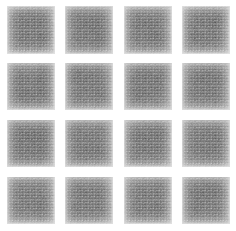

Epoch [0/5] Batch 200/938                   Loss D: -180.7762, loss G: 329.4807


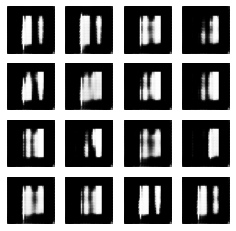

Epoch [0/5] Batch 400/938                   Loss D: -180.3215, loss G: 354.9272


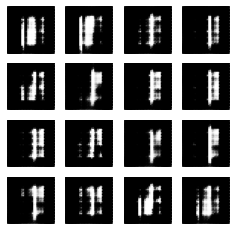

Epoch [0/5] Batch 600/938                   Loss D: -22.7550, loss G: -327.2479


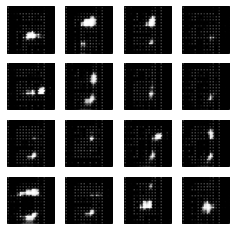

Epoch [0/5] Batch 800/938                   Loss D: -55.0865, loss G: 156.6628


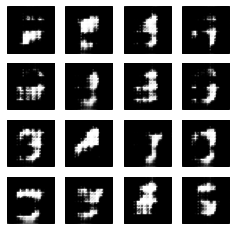

Epoch [1/5] Batch 0/938                   Loss D: -70.9048, loss G: 243.5403


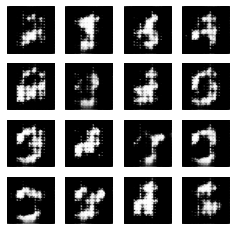

Epoch [1/5] Batch 200/938                   Loss D: -19.0299, loss G: -12.7451


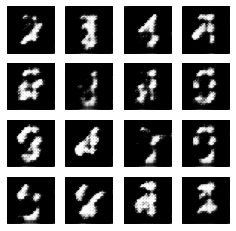

Epoch [1/5] Batch 400/938                   Loss D: -7.8250, loss G: 150.2575


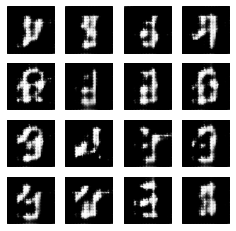

Epoch [1/5] Batch 600/938                   Loss D: -28.6484, loss G: -21.6583


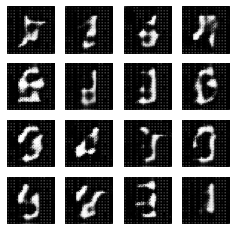

Epoch [1/5] Batch 800/938                   Loss D: -25.2236, loss G: -107.4206


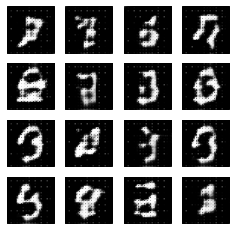

Epoch [2/5] Batch 0/938                   Loss D: -53.4423, loss G: 403.2567


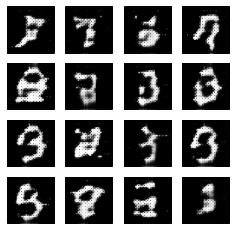

Epoch [2/5] Batch 200/938                   Loss D: -10.8079, loss G: -159.7076


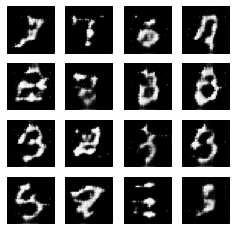

Epoch [2/5] Batch 400/938                   Loss D: -19.7269, loss G: -159.1741


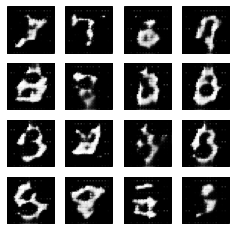

Epoch [2/5] Batch 600/938                   Loss D: -6.2177, loss G: 41.8896


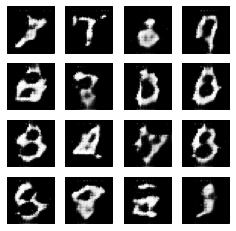

Epoch [2/5] Batch 800/938                   Loss D: -11.7672, loss G: -187.6794


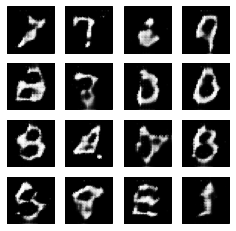

Epoch [3/5] Batch 0/938                   Loss D: -6.7396, loss G: 89.2152


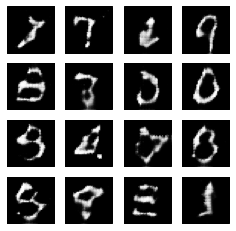

Epoch [3/5] Batch 200/938                   Loss D: -17.1411, loss G: -238.3517


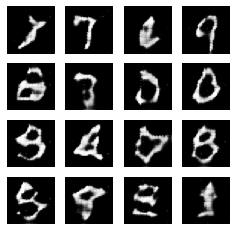

Epoch [3/5] Batch 400/938                   Loss D: -11.0584, loss G: 33.8801


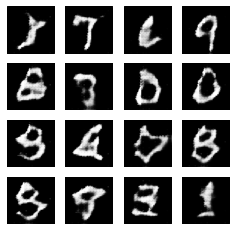

Epoch [3/5] Batch 600/938                   Loss D: -10.1400, loss G: 322.8576


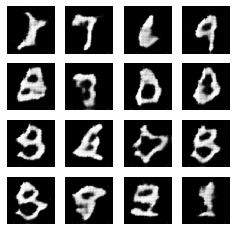

Epoch [3/5] Batch 800/938                   Loss D: -11.3677, loss G: 119.6993


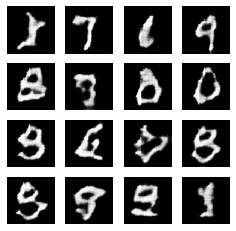

Epoch [4/5] Batch 0/938                   Loss D: -7.4646, loss G: 12.7394


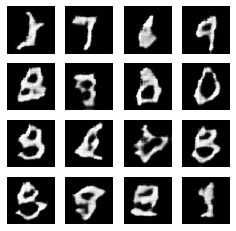

Epoch [4/5] Batch 200/938                   Loss D: -12.1934, loss G: 560.9229


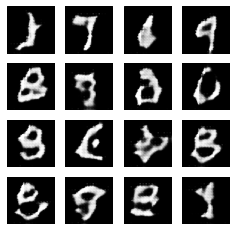

Epoch [4/5] Batch 400/938                   Loss D: -4.0003, loss G: 81.5947


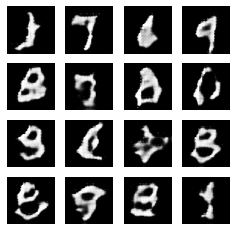

Epoch [4/5] Batch 600/938                   Loss D: -13.8269, loss G: -100.4821


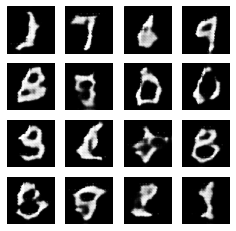

Epoch [4/5] Batch 800/938                   Loss D: -21.1511, loss G: -188.1967


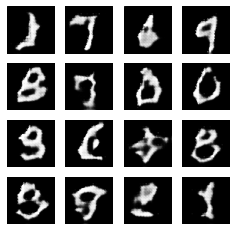

In [ ]:
"""
train.py
Training of DCGAN network on MNIST dataset with Discriminator
and Generator imported from models.py
"""

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
# from model import Discriminator, Generator, initialize_weights

# Hyperparameters etc.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 5e-5  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 1
NOISE_DIM = 100
NUM_EPOCHS = 5
FEATURES_DISC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
WEIGHT_CLIP = 0.01


transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

# If you train on MNIST, remember to set channels_img to 1
dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms,
                       download=True)

# comment mnist above and uncomment below if train on CelebA
#dataset = datasets.ImageFolder(root="celeb_dataset", transform=transforms)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
# initialize_weights(gen)
# initialize_weights(critic)

opt_gen = optim.RMSprop(gen.parameters(), lr=LEARNING_RATE)
opt_critic = optim.RMSprop(critic.parameters(), lr=LEARNING_RATE)

fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

gen.train()
critic.train()

for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        for _ in range(CRITIC_ITERATIONS):
          noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
          fake = gen(noise)
          critic_real = critic(real).reshape(-1)
          critic_fake = critic(fake).reshape(-1)
          loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
          critic.zero_grad()
          loss_critic.backward(retain_graph=True)
          opt_critic.step()

          for p in critic.parameters():
            p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)

        output = critic(fake).reshape(-1)
        loss_gen = -torch.mean(output)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 200 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(
                    real[:32], normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32], normalize=True
                )
                fake_16 = fake.view(-1, 64, 64)[:16]
                import matplotlib.pyplot as plt
                fig = plt.figure(figsize=(4,4))
                for i in range(16):
                    plt.subplot(4,4,i+1)
                    plt.imshow(fake_16[i].to('cpu'), cmap='gray')
                    plt.axis('off')
                plt.show()
                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1